# Classification

Previously we mentioned that the most common supervised learning task are regression (predicting values) and classification (predicting classes).Now we will turn our attetion to classification systems.

## MNIST

We will be using the MNIST dataset, which is a set of 70, 000 small images of digits handwritten by hibh school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

In [6]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [8]:
# Fetch the MNIST dataset:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Data sets loaded by Scikit-learn generally have similar dictionary structure including:

* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels

Each image is 28x28 pixels and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black).

In [9]:
mnist.data.shape

(70000, 784)

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [11]:
y.shape

(70000,)

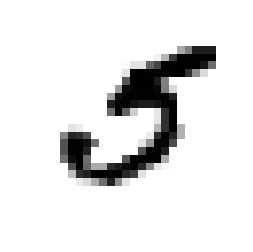

In [12]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

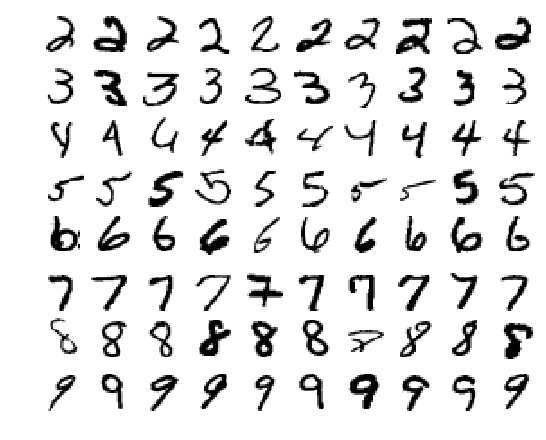

In [13]:
# %load some_images_MNIST_dataset.py
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]

    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")


mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
mnist["data"], mnist["target"]
X, y = mnist["data"], mnist["target"]

plt.figure(figsize=(9,9))
example_images = np.r_[X[12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()


In [31]:
y[36000]

5

**You should always create a test set and a set it aside before inspecting the data closely.**. The MNIST dataset is actaully already split into a training set (the first 60,000) and a test set (the last 10,000)

In [32]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle the training set; this garantee that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get may similar instances in a row.

In [33]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let's simplify the problem for now and only try to idenfity one digit. This "5-detector" will be an example of a *binary classifier*, capable of distinguishig between just two clases, 5 and not-5.

In [34]:
y_train_5 = (y_train == 5)  #true for all 5s.
y_test_5 = (y_test == 5)

A good place to start is with a *Stochastic Gradient Descent (SGD) classifier*. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instance independly, one a at time.

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

It detects images of the number 5:

In [36]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use *cross-validation*. Let's use the *cross_val_score()* function to evaluate the classifier model using K-fold cross-validation, with tree folds.

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96565, 0.9611 , 0.9612 ])

Occasionally we will need more contrl over the cross-validation process that what Scikit-Learn provides. In this case, you can implement cross-validation yourself.

In [38]:
from own_cross_val_score import own_cross_val

r = own_cross_val(sgd_clf, X_train, y_train_5)
r

[0.96565, 0.9611, 0.9612]

Wow! Above **95% accuracy** (ratio of correct prediction) on all cross-validation folds?. This looks amazing. Let's look at a very dumb classifier that just classifies every single image in the "not-5" class

In [39]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [40]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91245, 0.90855, 0.90795])

That's right, it has over 90% accuracy! this is simply because only about 10% of the images are 5s, so if you always guess that an image is *not a 5*, you will be right about 90% of the time.

This demostrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some clases are much more frequent that others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*. The general idea is to count the number of times instances of a class A are classifies as class B.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. Insted, you can use the *cross_val_predict()* function:

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the *confusion_matrix()* function.

In [42]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[54300,   279],
       [ 1962,  3459]])

Each row in a confusion matrix represents an *actual class*, while column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*): 53,272 of them were correctly classified as non-5s (they are called **true negatives**), while the remaining 1,307 were wrongly classified as 5s (**false positives**). The second row considers the the images of 5s (the *positive class*): 1,077 were wrongly classifies as non-5s (**false negatives**), while the remaining 4,344 were correctly classified as 5s (**true positives**). A perfect classifier would have only positives and true negatives, so its confusion matrix would have nonzero values only in its main diagonal.

In [43]:
y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

Some times you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called *precision* of the classifier:

\begin{equation*}
precision = \frac{TP}{TP + FP}
\end{equation*}

A trivial way to have perfect precision is to make one singe positive prediction and ensure it is correct ($precision = \frac{1}{1} = 100\%$). This would not be very useful since the classifier would ignore all but one positive instance. Precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate* (TPR): this is the ratio of positive instances that are correctly detected by the classifier:

\begin{equation*}
recall = \frac{TP}{TP + FN}
\end{equation*}

If you are confused about the confusion matrix, next image may help.

<img src="images/confusion_matrix.png" >

In [44]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9253611556982343

In [45]:
conf_matrix[1 ,1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

0.9253611556982343

In [46]:
recall_score(y_train_5, y_train_pred)

0.6380741560597676

In [47]:
conf_matrix[1 ,1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

0.6380741560597676

As you can see, when the 5-detector claims an image represents a 5, it is correct only 77% of the time. Moreover, it only detects 80% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_1$ *score*, in particular if you need a simple way to compare two classifiers. The $F_1$ score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

\begin{equation*}
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{equation*}

The $F_1$ score favors classifiers that have similar precision and recall.

Unfortunately, you have the *precision/recall tradeoff*, i. e., increasing precision reduces recall, and vice versa.

In [48]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7553226334752703

In [49]:
conf_matrix[1, 1] / (conf_matrix[1, 1] + (conf_matrix[1, 0] + conf_matrix[0 ,1]) / 2)

0.7553226334752702

#### Precision / Recall Tradeoff

To understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

<img src="images/decision_threshold.png">


Scikit-Learn does not let you set the threshold directly, but it does give you acces to the decision scores that it uses to make predictions. Instead of calling the classifier's *preduct()* method, you call its *decision_function()* method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.

In [50]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([348836.14406267])

In [51]:
# SGDClassifier uses a threshold equal to 0.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [52]:
# This confirms that raising the threshold decreases recall
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

How you can decide which threshold to use?. For this you will first nedd to get the scores of all instances in the training set using the *cross_val_predict()* function again, but this time specifying that you want it to return decision scores instead of predictions:

In [53]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now you can compute precision and recall for all possible thresholds using the *precision_recall_cuerve()*

In [54]:
y_scores.shape

(60000,)

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

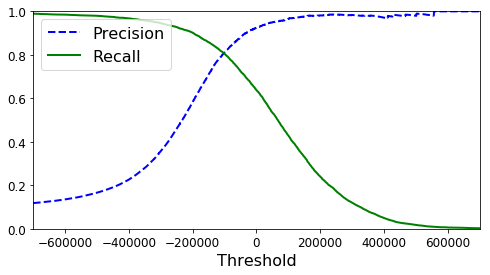

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [57]:
(y_train_pred == (y_scores > 0)).all()

True

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

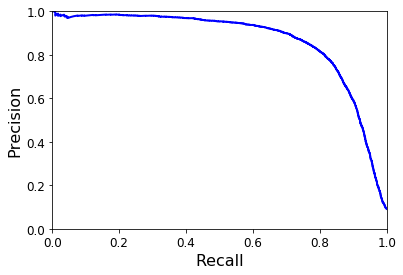

<Figure size 576x432 with 0 Axes>

In [59]:
from plt_precision_vs_recall import plot_precision_vs_recall

plot_precision_vs_recall(precisions, recalls)

Let's suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 70,000. 

In [35]:
y_train_pred_90 = (y_scores >70000)
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

Great, you have a 90% precision classifier (or close enough)!. As you can see, it is fairly easy to create a clasiffier with virtually any precision you want.

## the ROC Curve

The *Receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of ploting precision versus recall, the ROC cuerve plot the *true positive rate* (recall) against the *false positive rate*. It is equal to one minus the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*.

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

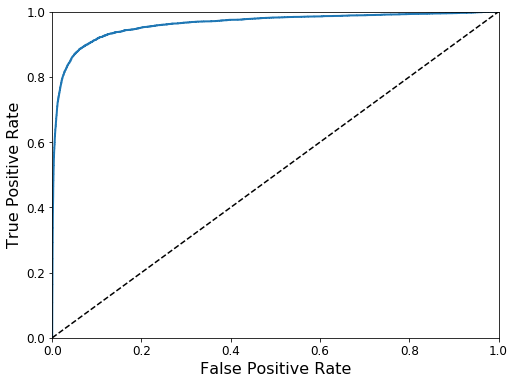

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces.

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1.

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [47]:
# let's train a RandomForest and compare its ROC curve and ROC AUC.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
# RandomForest does not have a decision_function(), instead it has a predict_proba method
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [48]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

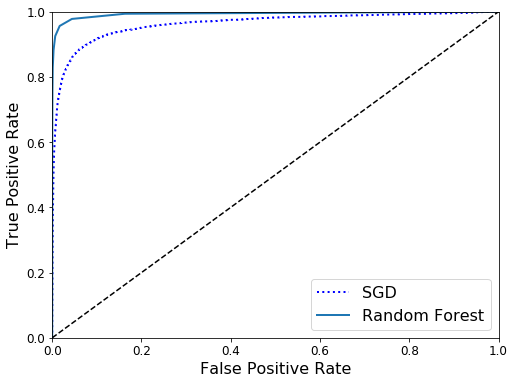

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()


In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, *multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes. Some algorithms are capable of handling multiple classes directly. Others are strictly binary classifiers. However, there are various strategies that you can use to perform multi class classification using multiple binary classifiers. For example the *one-versus-all* (OvA), also called *one-versus-the-rest*, or the *One-versus-One* (OvO) strategy.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM which uses OvO).

In [53]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [55]:
# show the 10 classifiers
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [56]:
np.argmax(some_digit_scores)

5

In [57]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [58]:
sgd_clf.classes_[5] # the highest score is indeed the one corresponding to class 5

5

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use *OneVsOneClassifier* or OneVsRestClassifier.

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [61]:
len(ovo_clf.estimators_)

45

In [62]:
# training a RandomForest is just as easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call *predict_proba()* to get the list of probabilities that the classifier assigned to each instance for each class.

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

#### Error Analysis

We will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyse the types of erros it makes.

First, you can look at the confusion matrix. You need to make predictions using the *cross_val_predict()* function, then call the *confusion_matrix()* function

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's *matshow()* function:

In [69]:
def plot_confunsion_matrix(matrix):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

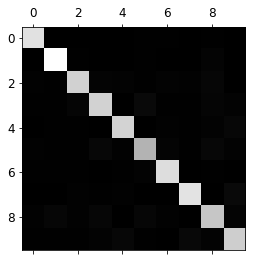

In [71]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

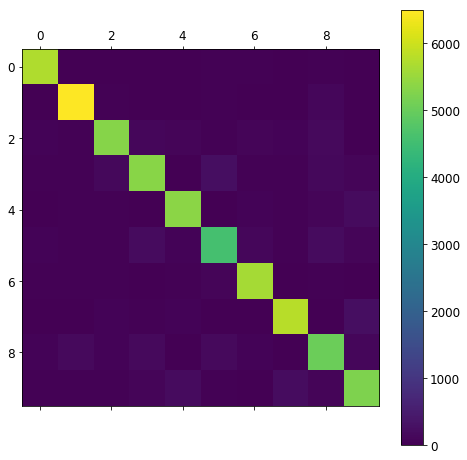

In [72]:
# in colors
plot_confunsion_matrix(conf_mx)
plt.show()

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare erro rates intead of absolute number of errors.

In [73]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now, let's fill the diagonal with zeros to keep only the errors, and let's plot the result:

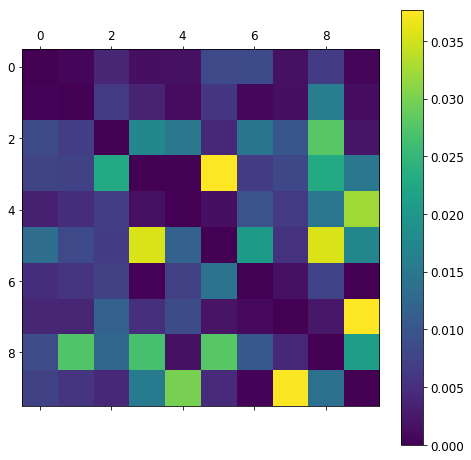

In [75]:
np.fill_diagonal(norm_conf_mx, 0)
plot_confunsion_matrix(norm_conf_mx)
plt.show()

Analysing the confusion matrix can often give you insights on ways to improve your classifier. Moreover, analyzing individual erros can also be a good way to grain insights on what your classifier is doing and why it is failing.

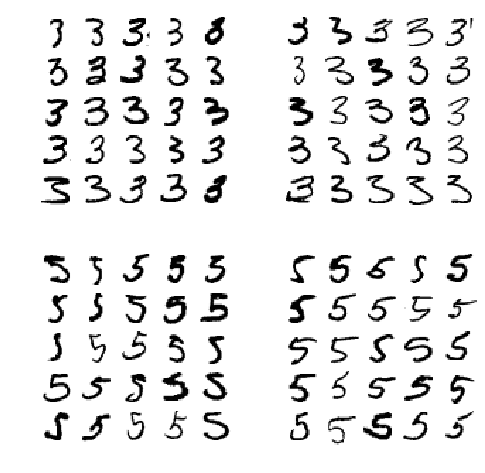

In [77]:
from some_images_MNIST_dataset import plot_digits


cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier. Let's look at a simple example:

In [78]:
from sklearn.neighbors import KNeighborsClassifier


y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8 or 9) and the second indicates whether or not it is odd. Now, notice that it outputs two labels:

In [79]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the $F_1$ score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

In [ ]:
# WARNING this cell may take a very long time (hours)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

### Multioutput Classification

The last type of classification to discuss where is called *multioutput-multiclass classification* (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i. e., it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images.

In [80]:
# create a noisi image
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

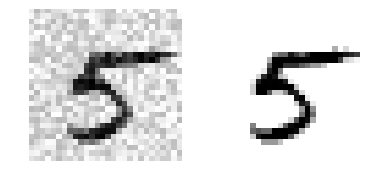

In [81]:
from some_images_MNIST_dataset import plot_digit

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

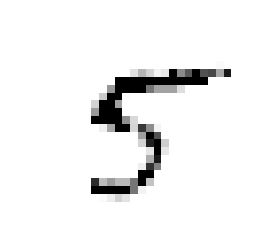

In [82]:
# now let's train the classifier and make it clean this image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)